# Deploying MMMs and CLVs in Production: Saving and Loading Models

In this article, we'll tackle the historically challenging process of deploying Bayesian models built with PyMC. Introducing a revolutionary deployment module, we bring unprecedented simplicity and efficiency to the deployment of PyMC models. As we prioritize user-friendly solutions, let's delve into how this innovation can significantly elevate your data science projects.


Recent release of PyMC-Marketing by [Labs](https://www.pymc-labs.io) proves to be a big hit [(PyMC-Marketing)](https://www.pymc-labs.io/blog-posts/pymc-marketing-a-bayesian-approach-to-marketing-data-science/). In the feedback one could see an ongoing theme, many of you have been requesting easy and robust way of deploying models to production. It’s been a long-standing problem with PyMC ( and most other PPLs). The reason for that is that there’s no obvious way, and doesn’t matter which approach you try it proves to be tricky. That is why we’re happy to announce the release of `ModelBuilder`, brand new PyMC-experimental module that addresses this need, and improves on the deployment process significantly.

The ModelBuilder module is a new feature of PyMC based models. It provides 2 easy-to-use methods: save() and load() that can be used after the model has been fit.save() allow easy preservation of the model to .netcdf format, and load() gives one-line replication of the original model. Users can control the prior settings with model_config, and customize the sampling process using sampler_config. Default values of those are working just fine, so first time give it a try without changing, and provide your own model_config and model_sampler if afterwards you want to try to customize it more for your use case!


For this notebook I'll use the example model used in [MMM Example Notebook](https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_example.html), but ommit the details of data generation and plotting functionalities, since they're out of scope for this introduction, I highly recommend to see that part as well, but for now let's focus on today's topic: Groundbreaking deployment improvements in PyMC-Marketing!

In [31]:
import arviz as az
import numpy as np
import pandas as pd

from pymc_marketing.mmm import DelayedSaturatedMMM

Let's load the dataset:

In [32]:
url = "https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/datasets/mmm_example.csv"
df = pd.read_csv(url)
df

,date_week,y,x1,x2,event_1,event_2,dayofyear,t,sin_order_1,cos_order_1,sin_order_2,cos_order_2
0,2018-04-02,3984.662237,0.318580,0.000000,0.0,0.0,92,0,0.999930,-0.011826,-0.023651,-0.999720
1,2018-04-09,3762.871794,0.112388,0.000000,0.0,0.0,99,1,0.991269,-0.131859,-0.261414,-0.965227
2,2018-04-16,4466.967388,0.292400,0.000000,0.0,0.0,106,2,0.968251,-0.249981,-0.484089,-0.875019
3,2018-04-23,3864.219373,0.071399,0.000000,0.0,0.0,113,3,0.931210,-0.364483,-0.678820,-0.734304
4,2018-04-30,4441.625278,0.386745,0.000000,0.0,0.0,120,4,0.880683,-0.473706,-0.834370,-0.551205
...,...,...,...,...,...,...,...,...,...,...,...,...
174,2021-08-02,3553.546148,0.033024,0.000000,0.0,0.0,214,174,-0.513901,-0.857849,0.881699,0.471812
175,2021-08-09,5565.509682,0.165615,0.863349,0.0,0.0,221,175,-0.613230,-0.789905,0.968786,0.247898
176,2021-08-16,4137.651485,0.171882,0.000000,0.0,0.0,228,176,-0.703677,-0.710520,0.999953,0.009676
177,2021-08-23,4479.041351,0.280257,0.000000,0.0,0.0,235,177,-0.783934,-0.620844,0.973402,-0.229104


But for our model we need much smaller dataset, many of the previous features were contributing to generation of others, now as our target variable is computed we can filter out not needed columns:

In [33]:
columns_to_keep = [
    "date_week",
    "y",
    "x1",
    "x2",
    "event_1",
    "event_2",
    "dayofyear",
]
seed: int = sum(map(ord, "mmm"))
rng =np.random.default_rng(seed=seed)

data = df[columns_to_keep].copy()

data["t"] = range(df.shape[0])
data.head()

,date_week,y,x1,x2,event_1,event_2,dayofyear,t
0,2018-04-02,3984.662237,0.318580,0.0,0.0,0.0,92,0
1,2018-04-09,3762.871794,0.112388,0.0,0.0,0.0,99,1
2,2018-04-16,4466.967388,0.292400,0.0,0.0,0.0,106,2
3,2018-04-23,3864.219373,0.071399,0.0,0.0,0.0,113,3
4,2018-04-30,4441.625278,0.386745,0.0,0.0,0.0,120,4


## _Model Creation_
After we have our dataset ready, we could proceed straight to our model definition, but first to show the full potential of one of the new features: `model_config` we need to use some of our data to define our prior for sigma parameter for each of the channels. `model_config` is a customizable dictionary with keys corresponding to priors within the model, and values containing a dictionaries with parameters necessary to initialize them. Later on we'll learn that through the `save()` method we can preserve our priors contained inside the `model_config`, to allow complete replication of our model.

### model_config

`default_model_config` attribute of every model inheriting from `ModelBuilder` will allow you to see which priors are available for customization. To see it simply initialize a dummy model:

In [34]:
dummy_model = DelayedSaturatedMMM(date_column = '', channel_columns= '', adstock_max_lag = 4)
dummy_model.default_model_config

{'intercept': {'mu': 0, 'sigma': 2},
 'beta_channel': {'sigma': 2, 'dims': ('channel',)},
 'alpha': {'alpha': 1, 'beta': 3, 'dims': ('channel',)},
 'lam': {'alpha': 3, 'beta': 1, 'dims': ('channel',)},
 'sigma': {'sigma': 2},
 'gamma_control': {'mu': 0, 'sigma': 2, 'dims': ('control',)},
 'mu': {'dims': ('date',)},
 'likelihood': {'dims': ('date',)},
 'gamma_fourier': {'mu': 0, 'b': 1, 'dims': 'fourier_mode'}}

You can change only the prior parameters that you wish, no need to alter all of them, unless you'd like to!
In this case we'll just simply replace our sigma for beta_channel with our computed one:

First, let's compute the share of spend per channel:

In [35]:
total_spend_per_channel = data[["x1", "x2"]].sum(axis=0)

spend_share = total_spend_per_channel / total_spend_per_channel.sum()

spend_share

x1    0.65632
x2    0.34368
dtype: float64

Next, we specify the `sigma`parameter per channel:

In [36]:
# The scale necessary to make a HalfNormal distribution have unit variance
HALFNORMAL_SCALE = 1 / np.sqrt(1 - 2 / np.pi)

n_channels = 2

prior_sigma = HALFNORMAL_SCALE * n_channels * spend_share.to_numpy()

prior_sigma.tolist()

[2.1775326025486734, 1.140260877391939]

In [37]:
custom_beta_channel_prior = {'beta_channel': {'sigma': prior_sigma, 'dims': ('channel',)}}
my_model_config = dummy_model.default_model_config| custom_beta_channel_prior

As mentioned in the original notebook: "_For the prior specification there is no right or wrong answer. It all depends on the data, the context and the assumptions you are willing to make. It is always recommended to do some prior predictive sampling and sensitivity analysis to check the impact of the priors on the posterior. We skip this here for the sake of simplicity. If you are not sure about specific priors, the `DelayedSaturatedMMM` class has some default priors that you can use as a starting point._"

The second feature that we can use for model definition is `sampler_config`. Similar to `model_config`, it's a dictionary that gets saved and contains things you'd usually pass to the `fit()` kwargs. It's not mandatory to create your own `sampler_config`; if not provided, both `model_config` and `sampler_config` will default to the forms specified by PyMC Labs experts, which allows for the usage of all model functionalities. The default `sampler_config` is left empty because the default sampling parameters usually prove sufficient for a start.

In [38]:
dummy_model.default_sampler_config

{}

In [39]:
my_sampler_config = {
    'tune':1000,
    'draws':1000,
    'chains':4,
    'target_accept':0.95,
}

Let's finally assemble our model!

In [40]:
mmm = DelayedSaturatedMMM(
    model_config = my_model_config,
    sampler_config = my_sampler_config,
    date_column="date_week",
    channel_columns=["x1", "x2"],
    control_columns=[
        "event_1",
        "event_2",
        "t",
    ],
    adstock_max_lag=8,
    yearly_seasonality=2,
)

An important thing to note here is that in the new version of `DelayedSaturatedMMM`, we don't pass our dataset to the class constructor itself. This is due to a reason I've mentioned before - it supports `sklearn` transformers and validations that require a usual X, y split and typically expect the data to be passed to the `fit()` method.

## _Model Fitting_

Let's split the dataset:

In [41]:
X = data.drop('y',axis=1)
y = data['y']

All that's left now is to finally fit the model:

As you can see below, you can still pass the sampler kwargs directly to `fit()` method. However, only those kwargs passed using `sampler_config` will be saved. Therefore, only these will be available after loading the model.

In [42]:
mmm.fit(X=X, y=y, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_channel, alpha, lam, sigma, gamma_control, gamma_fourier]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [alpha, beta_channel, gamma_control, gamma_fourier, intercept, lam, likelihood, sigma]
Sampling: [likelihood]


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> fit_data

The `fit()` method automatically builds the model using the priors from `model_config`, and assigns the created model to our instance. You can access it as a normal attribute.

In [43]:
type(mmm.model)

pymc.model.Model

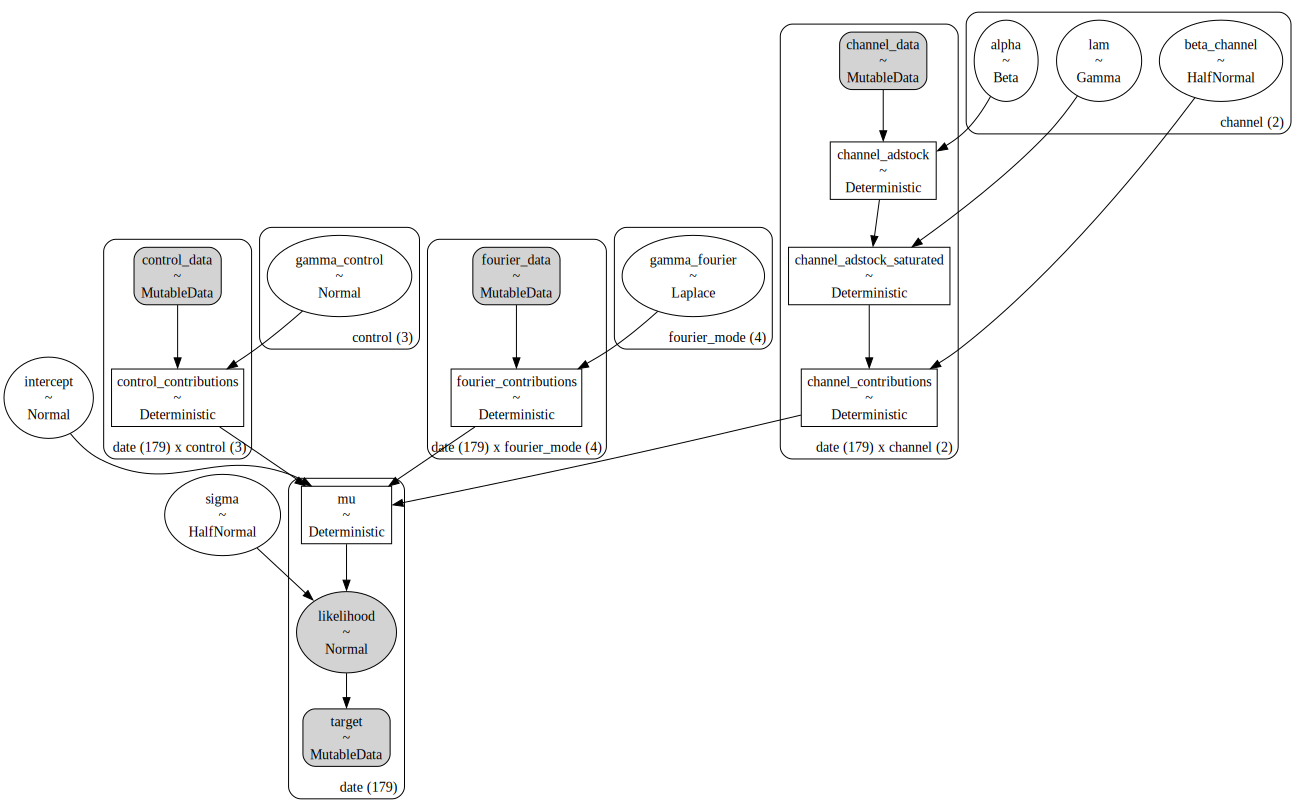

In [44]:
mmm.graphviz()

posterior trace can be accessed by `fit_result` attribute

In [45]:
mmm.fit_result

<xarray.Dataset>
Dimensions:                    (chain: 4, draw: 1000, control: 3,
                                fourier_mode: 4, channel: 2, date: 179)
Coordinates:
  * chain                      (chain) int64 0 1 2 3
  * draw                       (draw) int64 0 1 2 3 4 5 ... 995 996 997 998 999
  * control                    (control) <U7 'event_1' 'event_2' 't'
  * fourier_mode               (fourier_mode) <U11 'sin_order_1' ... 'cos_ord...
  * channel                    (channel) <U2 'x1' 'x2'
  * date                       (date) <U10 '2018-04-02' ... '2021-08-30'
Data variables: (12/13)
    intercept                  (chain, draw) float64 0.3381 0.3361 ... 0.3479
    gamma_control              (chain, draw, control) float64 0.2968 ... 0.00...
    gamma_fourier              (chain, draw, fourier_mode) float64 -0.002612 ...
    beta_channel               (chain, draw, channel) float64 0.3718 ... 0.2628
    alpha                      (chain, draw, channel) float64 0.4162 ... 0.2007
    lam                        (chain, draw, channel) float64 4.26 ... 2.758
    ...                         ...
    channel_adstock            (chain, draw, date, channel) float64 0.1868 .....
    channel_adstock_saturated  (chain, draw, date, channel) float64 0.3781 .....
    channel_contributions      (chain, draw, date, channel) float64 0.1406 .....
    control_contributions      (chain, draw, date, control) float64 0.0 ... 0...
    fourier_contributions      (chain, draw, date, fourier_mode) float64 -0.0...
    mu                         (chain, draw, date) float64 0.4769 ... 0.5924
Attributes:
    created_at:                 2023-08-03T11:09:14.027598
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.6.1
    sampling_time:              29.821417093276978
    tuning_steps:               1000

If you wish to inspect the entire inference data, use the `idata` attribute. Within `idata`, you can find the entire dataset passed to the model under `fit_data`.

In [46]:
mmm.idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> fit_data

## `Save` and `load`

All the data passed to the model on initialisation is stored in `idata.attrs`. This will be used later in the `save()` method to convert both this data and all the fit data into the netCDF format.

Simply specify the path to which you'd like to save your model:

In [47]:
mmm.save('my_saved_model.nc')

And pass it to the `load()` method when it's needed again on the target system:

In [48]:
loaded_model = DelayedSaturatedMMM.load('my_saved_model.nc')

/Users/michalraczycki/Documents/pymc-marketing/.conda/envs/pymc-marketing/lib/python3.10/site-packages/arviz/data/inference_data.py:153: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(


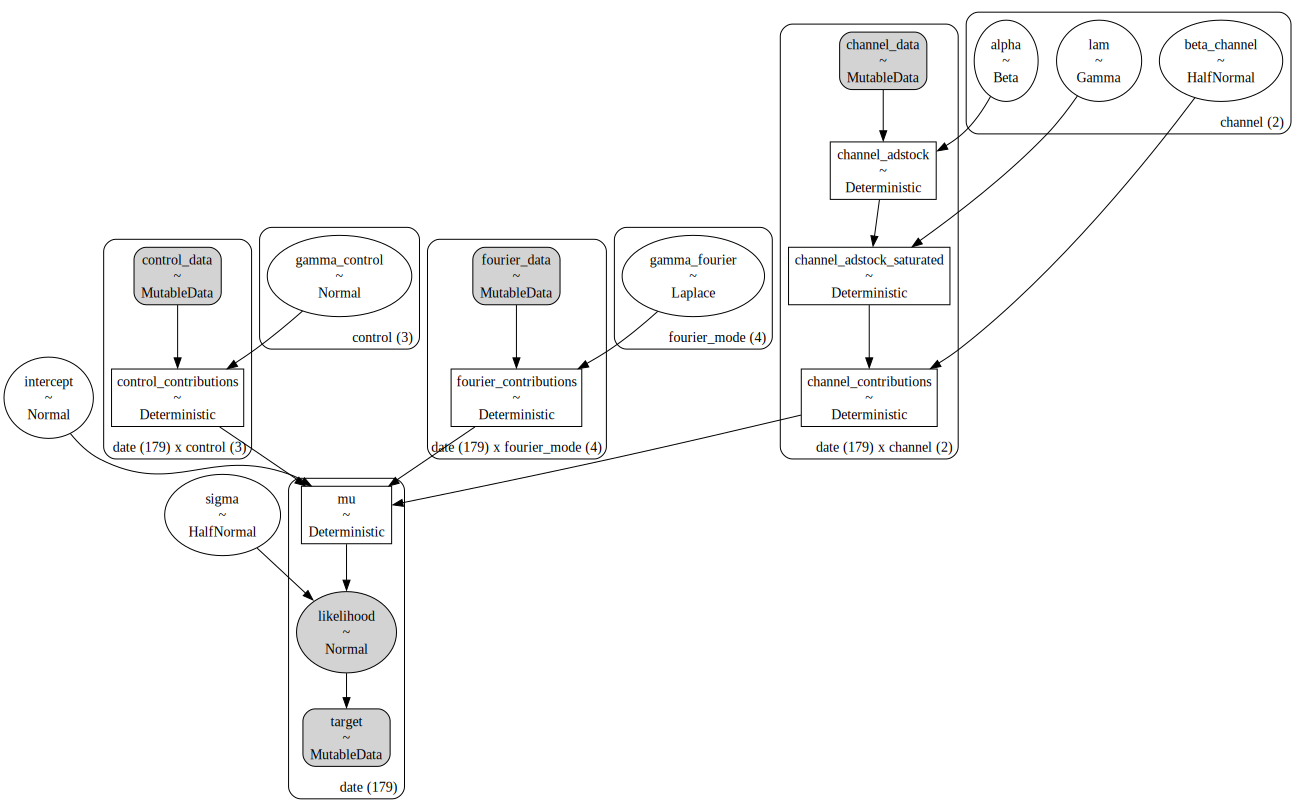

In [49]:
loaded_model.graphviz()

In [50]:
loaded_model.idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> fit_data

A model loaded in this way is ready to be used for sampling and prediction, and has access to all previous samples and data.

In [51]:
with loaded_model.model:
    new_predictions = loaded_model.sample_posterior_predictive(X, extend_idata = True, combined = False, random_seed = rng)
new_predictions

Sampling: [likelihood]


<xarray.Dataset>
Dimensions:     (chain: 4, draw: 1000, date: 179)
Coordinates:
  * chain       (chain) int64 0 1 2 3
  * draw        (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * date        (date) <U10 '2018-04-02' '2018-04-09' ... '2021-08-30'
Data variables:
    likelihood  (chain, draw, date) float64 0.4907 0.4282 ... 0.5548 0.5396
Attributes:
    created_at:                 2023-08-03T11:09:22.139450
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.6.1

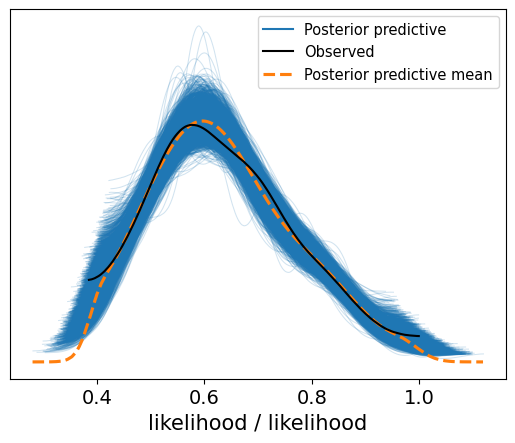

In [52]:
az.plot_ppc(loaded_model.idata);

## Summary:

In summary, this article introduces the revolutionary ModelBuilder, a new PyMC-experimental module that simplifies the deployment of PyMC Bayesian models. It addresses a historic challenge faced by users of PyMC and most PPLs by offering a user-friendly and efficient approach to model deployment. The ModelBuilder provides two straightforward methods, save() and load(), which streamline the model preservation and replication process post fitting. Users are offered flexibility in controlling the prior settings with model_config and customizing the sampling process via sampler_config.

The use of an example model from the MMM Example Notebook demonstrates the practical implementation of ModelBuilder, emphasizing its ability to enhance model sharing among teams without the necessity for extensive domain knowledge about the model. The deployment improvements in PyMC-Marketing brought about by ModelBuilder are not only user-friendly but also significantly enhance efficiency, making PyMC models more accessible for a wider audience.

Even though this introduction is using `DelayedSaturatedMMM`, functionalities from `ModelBuilder` are available in the CLV models as well.